In [3]:
import os
import lightning as L
import torch

from deepmash.data_processing.constants import *
from deepmash.data_processing.common import get_dataloaders, ToLogMel, get_vocal_rms
from deepmash.data_processing.gtzan_stems import GTZANStemsDataset
from deepmash.data_processing.musdb18 import MUSDB18Dataset
from deepmash.models.cocola_cnn import CocolaCNN
from deepmash.utils.utils import get_device
from deepmash.utils.plotting_utils import display_random_chunk
from deepmash.models.train import training_run

# reload imported modules automatically (so you dont have to restart kernel when changing .py files)
%load_ext autoreload
%autoreload 2

In [4]:
ds_gtzan = GTZANStemsDataset(
    root_dir="../datasets/gtzan-stems",
    already_preprocessed=True,
    preprocess_transform=ToLogMel(),
)

ds_musdb_train = MUSDB18Dataset(
    root_dir="../datasets/musdb18",
    split="train",
    already_preprocessed=True,
    preprocess_transform=ToLogMel(),
)
ds_musdb_test = MUSDB18Dataset(
    root_dir="../datasets/musdb18",
    split="test",
    already_preprocessed=True,
    preprocess_transform=ToLogMel(),
)

print(len(ds_gtzan), len(ds_musdb_train), len(ds_musdb_test))
print(ds_gtzan[42].vocals.shape, ds_musdb_train[42].vocals.shape)

1535 1243 841
torch.Size([64, 751]) torch.Size([64, 751])


In [5]:
# check that dataloaders and forward-pass works

train_loader, val_loader, test_loader = get_dataloaders(
    dataset=ds_gtzan,
    batch_size=16,   
    num_workers=0,
    val_split=0.1,
    test_split=0.1
)

device = get_device()
print(f"Using device: {device}")

model = CocolaCNN(learning_rate=0.001, embedding_dim=512, dropout_p=0.1)
model = model.to(device)

batch = next(iter(train_loader))
batch = batch.to(device)
print(batch.vocals.shape, batch.non_vocals.shape)

model(batch).shape

Using device: mps
torch.Size([16, 64, 751]) torch.Size([16, 64, 751])


torch.Size([16, 16])

tensor(35.8186) tensor(16.5338) tensor(12.0872) tensor(96.4801)


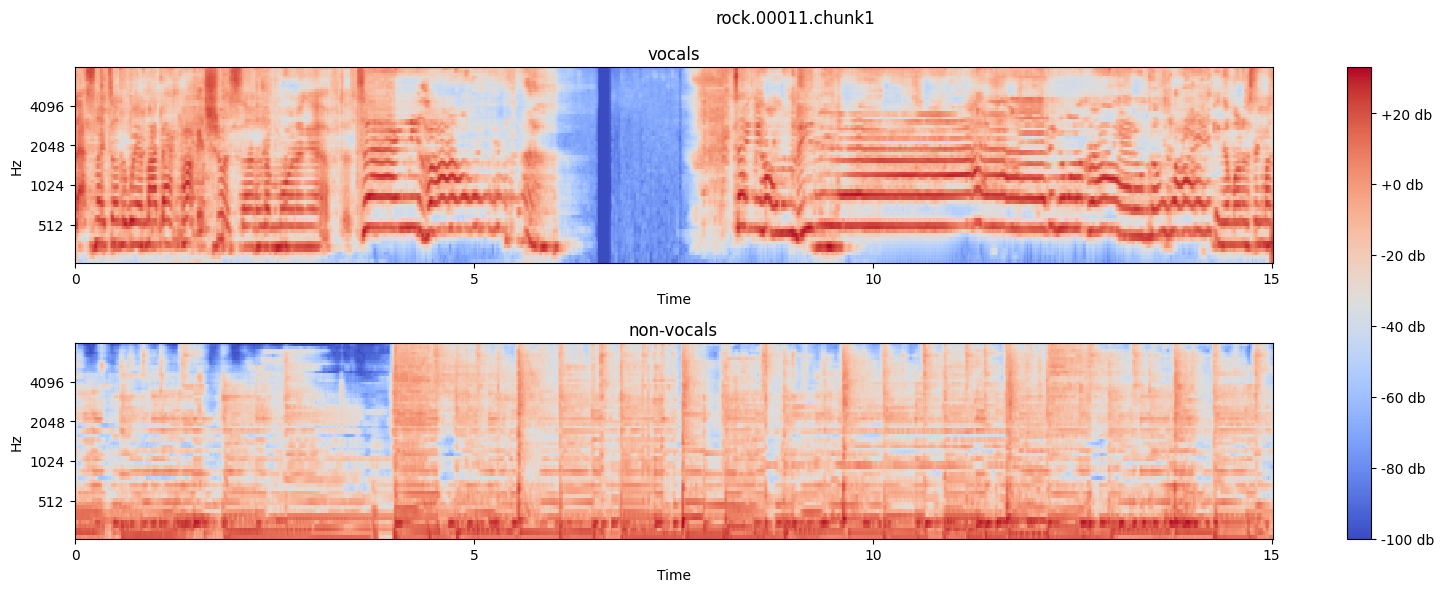

In [29]:
# check vocal energy distribution
ds = ds_gtzan
vocal_energy = torch.tensor([get_vocal_rms(sample.vocals) for sample in ds])
print(vocal_energy.mean(), vocal_energy.std(), vocal_energy.min(), vocal_energy.max())

# check audio / spectrograms of some samples
for _ in range(1):
    display_random_chunk(ds)

In [ ]:
training_run(
    dataset=ds_gtzan,
    model=model,
    batch_size=16,
    num_workers=0,
    overfit_batches=0,
    max_epochs=10,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | encoder    | EfficientNetEncoder | 4.7 M  | train
1 | layer_norm | LayerNorm           | 1.0 K  | train
2 | tanh       | Tanh                | 0      | train
3 | similarity | BilinearSimilarity  | 262 K  | train
-----------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.704    Total estimated model params size (MB)
255       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/valle/Library/CloudStorage/OneDrive-KTH/Dokument/KTH/musik-dt2470/deep-mash/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/valle/Library/CloudStorage/OneDrive-KTH/Dokument/KTH/musik-dt2470/deep-mash/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]